# Version information

SCidatatool v2.4.8
pyleecan v1.3.9 에서 작성 

In [154]:
femm = _FEMMHandler()
femm.openfemm(0)
femm.opendocument('D:/NGV/DN8/DN8.fem')
# femm.opendocument('D:/NGV/DN8/DN8.fem')

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'DN8_tota_anti'}, xlabel='Position along x-axis [m]', ylabel='Position along y-axis [m]'>)

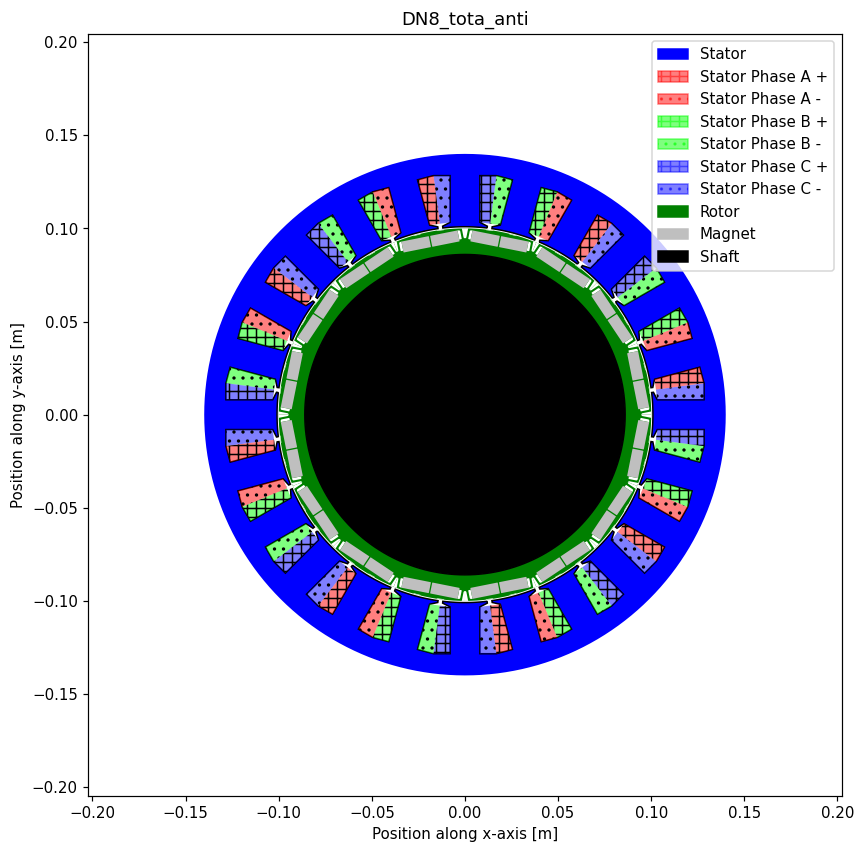

In [151]:
from os.path import join
from pyleecan.Functions.load import load
from pyleecan.Classes._FEMMHandler import _FEMMHandler

Simu_DIR='D:/NGV/DN8'
DN8=load(join(Simu_DIR, "DN8_tota_anti.json"))
DN8.plot()



## Simu 1 Simulation (No-load)

In [145]:
# from numpy import (
#     zeros,
#     exp,
#     pi,
#     real,
#     meshgrid,
#     mean,
# )
# from pyleecan.Classes.ForceMT import ForceMT
# from pyleecan.Classes.OPdq import OPdq
# from pyleecan.Classes.Simu1 import Simu1
# from pyleecan.Classes.MagFEMM import MagFEMM
# from pyleecan.Classes.InputCurrent import InputCurrent
# from pyleecan.Functions.Plot import dict_2D, dict_3D 

rpm=2000

simu_noload = Simu1(name="DN8", machine=DN8)
simu_noload.input = InputCurrent(
    OP=OPdq(Id_ref=0, Iq_ref=0, N0=rpm),
    Ir=None,
    Na_tot=2 ** 16, # angle    
    Nt_tot=2 ** 8, #Time
)

simu_noload.elec = None
simu_noload.mag = MagFEMM(
    type_BH_stator=0,  # 0 to use the material B(H) curve, 
    type_BH_rotor=0,   # 0 to use the material B(H) curve, 
    is_periodicity_a=True,
    is_periodicity_t=True,
    Kmesh_fineness=1,
    Kgeo_fineness=1,

)
simu_noload.force = ForceMT(
    is_periodicity_a=True,
    is_periodicity_t=True,
)

simu_noload.mag.is_get_meshsolution = True # To get FEA mesh for latter post-procesing
# simu1.mag.is_save_meshsolution_as_file = True # To save FEA results in a dat file

simu_noload.mag.nb_worker = 8
out_noload = simu_noload.run()
AGSF_noload = out_noload.force.AGSF 

[03:23:16] Starting running simulation DN8 (machine=DN8_tota_anti)
[03:23:16] Starting Magnetic module
[03:23:17] Computing Airgap Flux in FEMM
[03:23:30] Starting Force module
[03:23:30] End of simulation DN8


## Simu2 simulation (Load)


In [133]:
# 부하 해석
import math
# I0, Phi0 설정
I0_rms = 250/math.sqrt(2) # Maximum current [Arms]
Phi0 = 140*pi/180  # Maximum Torque Per Amp
# 해당 Id/Iq 계산
Id_ref = (I0_rms*exp(1j*Phi0)).real
Iq_ref = (I0_rms*exp(1j*Phi0)).imag

#Load1 정현파 전류의 정의 (OPdq)
out_load=out_noload.copy()
simu_load=out_load.simu
simu_load.name="DN8_load"
simu_load.input = InputCurrent(
    OP=OPdq(Id_ref=Id_ref, Iq_ref=Iq_ref,N0=rpm),
    Ir=None,
)
out_load = simu_load.run()
# simu_vop.var_simu = varload

[03:19:03] Starting running simulation DN8_load (machine=DN8_tota_anti)
[03:19:03] Starting Magnetic module
[03:19:04] Solving time steps: 0%
[03:19:04] Solving time steps: 0%
[03:19:04] Solving time steps: 0%
[03:19:04] Solving time steps: 0%
[03:19:05] Solving time steps: 0%
[03:19:05] Solving time steps: 0%
[03:19:05] Solving time steps: 0%
[03:19:06] Solving time steps: 0%
[03:19:13] Solving time steps: 25%
[03:19:13] Solving time steps: 25%
[03:19:13] Solving time steps: 25%
[03:19:13] Solving time steps: 25%
[03:19:14] Solving time steps: 25%
[03:19:14] Solving time steps: 25%
[03:19:14] Solving time steps: 25%
[03:19:15] Solving time steps: 25%
[03:19:19] Solving time steps: 50%
[03:19:19] Solving time steps: 50%
[03:19:19] Solving time steps: 50%
[03:19:19] Solving time steps: 50%
[03:19:20] Solving time steps: 50%
[03:19:20] Solving time steps: 50%
[03:19:20] Solving time steps: 50%
[03:19:20] Solving time steps: 50%
[03:19:24] Solving time steps: 75%
[03:19:25] Solving time s

# Plot &  Data Check(Load) -3D Airgap Flux density 

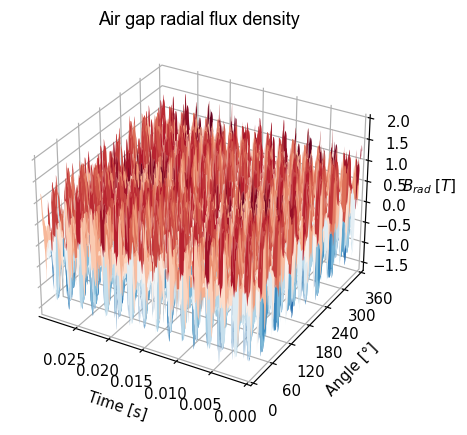

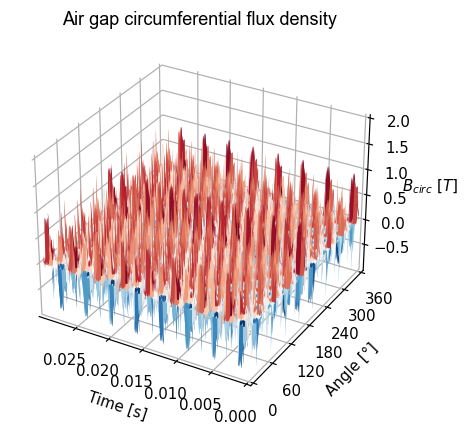

In [134]:
# 기계적 한주기 및 한바퀴 
out_load.mag.B.plot_3D_Data("time", "angle{°}", is_2D_view=False,z_max=2)


## Data check(Load) 공간 자속밀도분포(공극) 

### Spatial Distribution

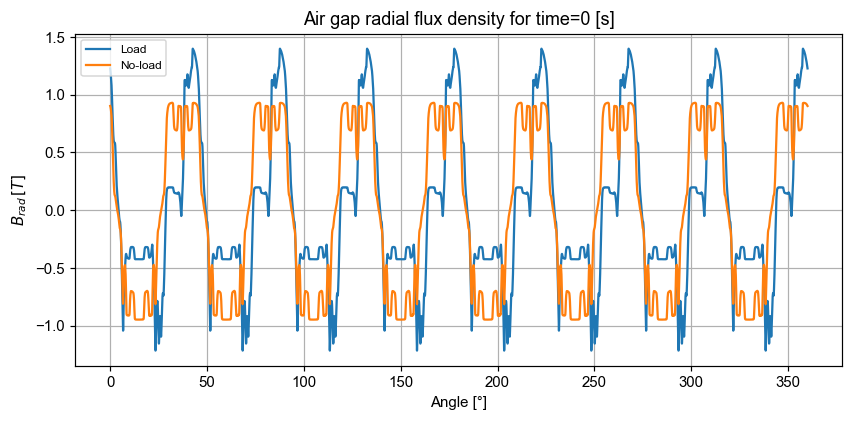

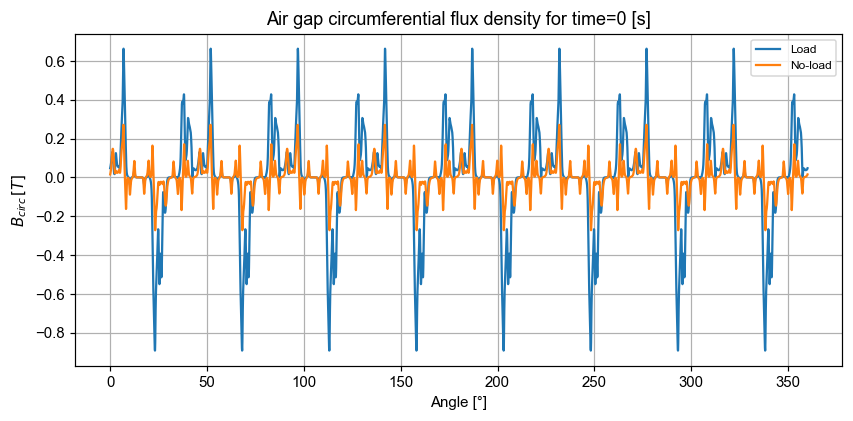

In [64]:
# 공간적 자속 밀도 분포도 비교
out_load.mag.B.plot_2D_Data("angle{°}",data_list=[out_noload.mag.B],legend_list=['Load','No-load'])

### Temporal Distribution

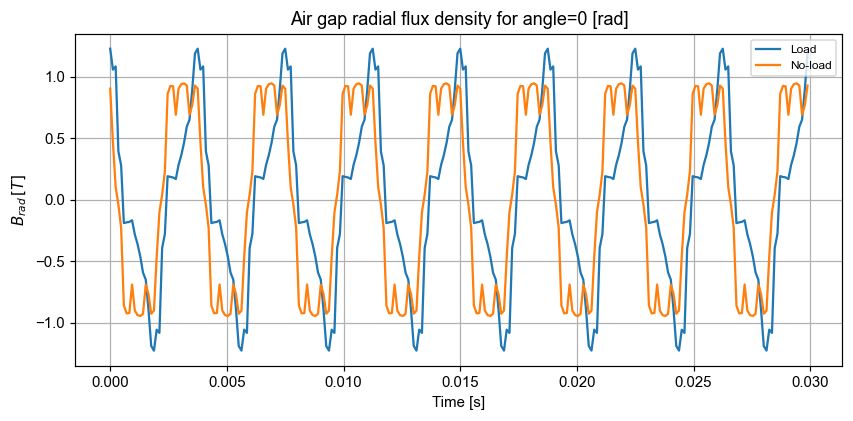

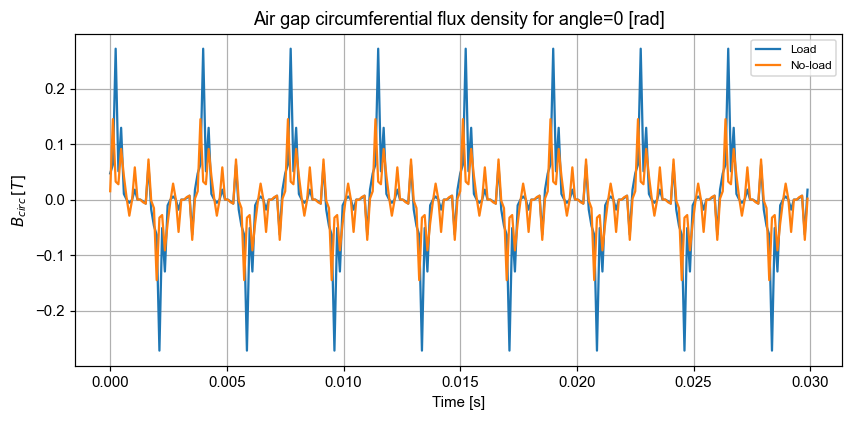

In [65]:
# 시간적 자속 밀도 분포도 비교
out_load.mag.B.plot_2D_Data("time",data_list=[out_noload.mag.B],legend_list=['Load','No-load'])

## FFT of B

#### 1D FFT

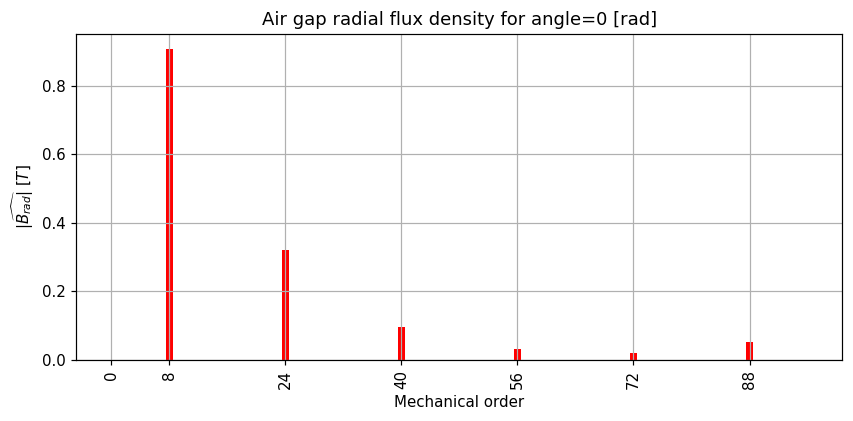

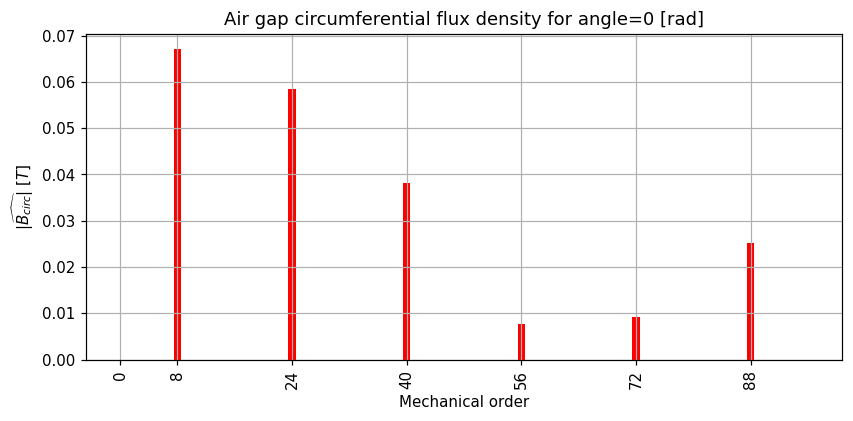

In [106]:
out_load.mag.B.plot_2D_Data("freqs->mech_order=[0,100]", **dict_2D)


#### 2D FFT(3D view)

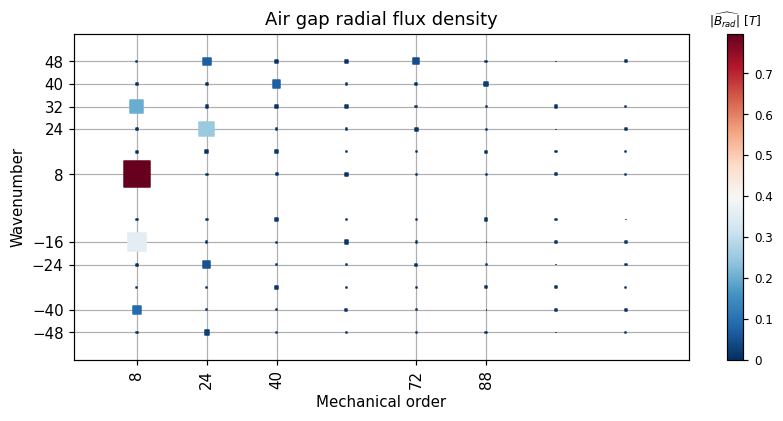

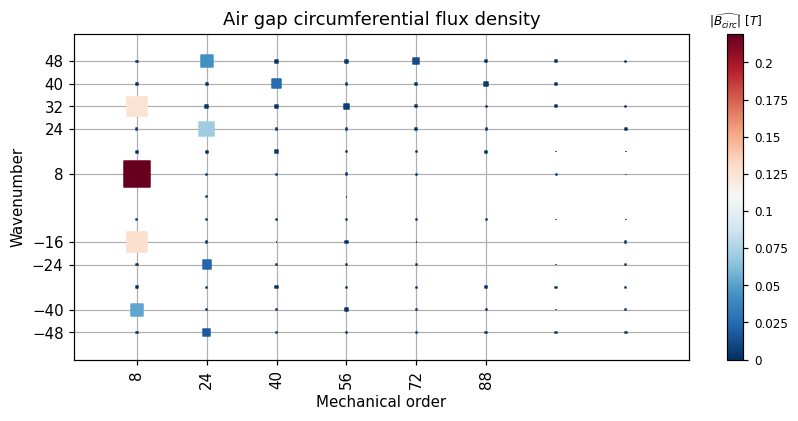

In [78]:
out_load.mag.B.plot_3D_Data(
    "freqs->mech_order=[0,96*2]",
    "wavenumber=[-48,48]",
    N_stem=100,
    **dict_3D
)

# Plot & Data Check Electromagnetic Force Density[P]

## Data check(Load vs No load)


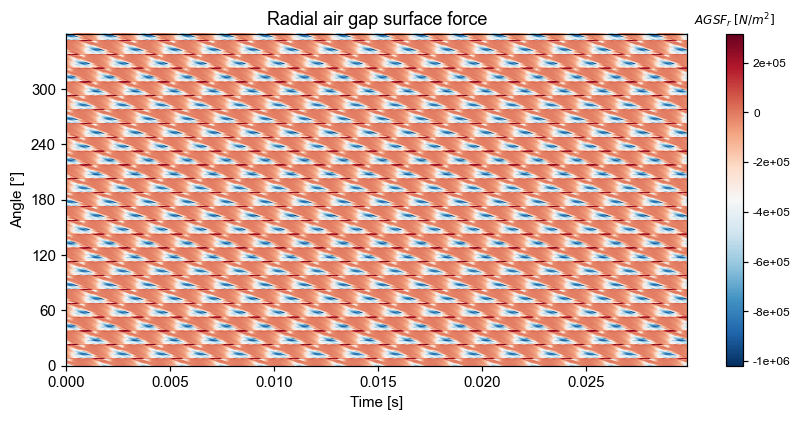

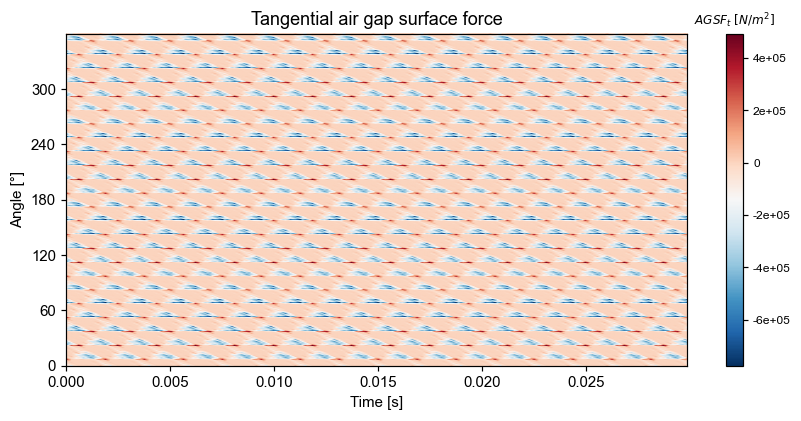

In [135]:
# Force 확인 - 부하해석 결과 2D (Angle / Time)
AGSF_load.plot_3D_Data("time", "angle{°}", is_2D_view=True)

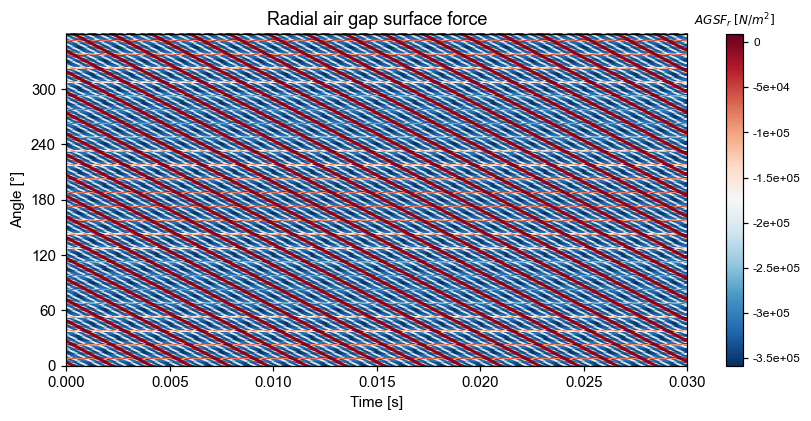

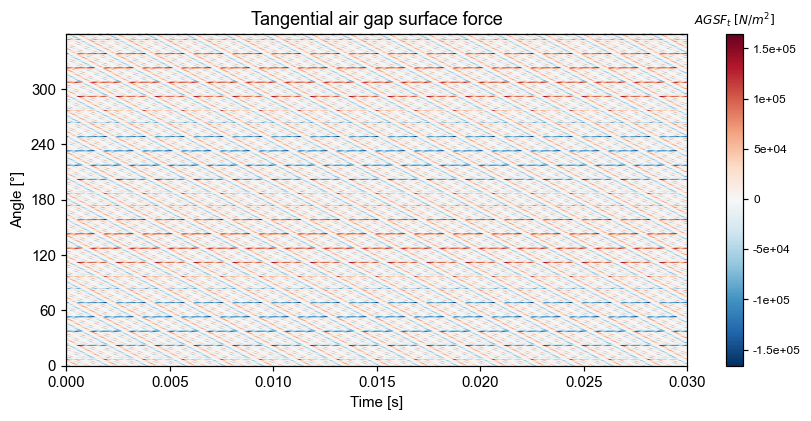

In [92]:
# 무부하 해석 결과 2D (Angle / Time)
AGSF_noload.plot_3D_Data("time", "angle{°}", is_2D_view=True,x_max=0.03)


## FFT of P

### 2D FFT

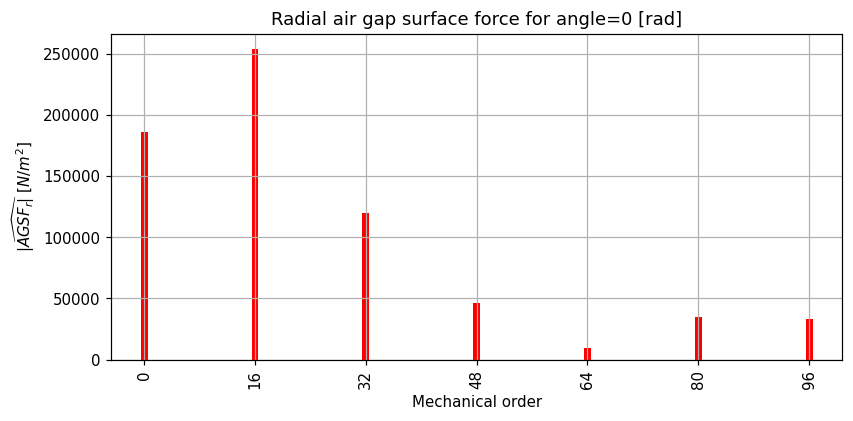

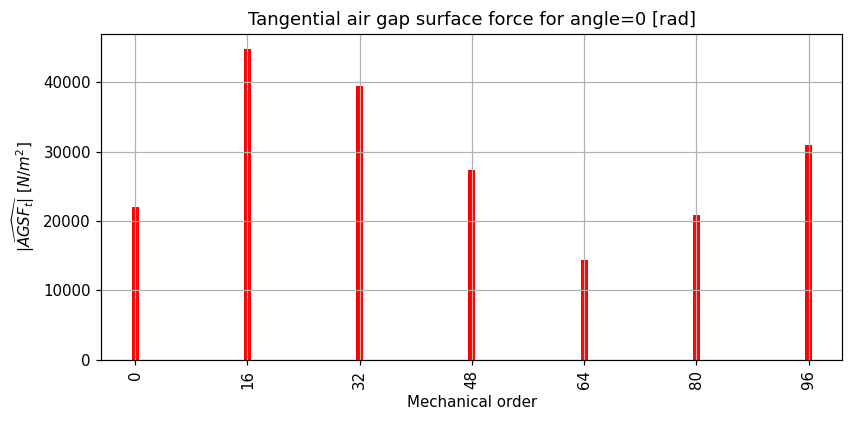

In [155]:
AGSF_load.plot_2D_Data("freqs->mech_order=[0,100]", **dict_2D)

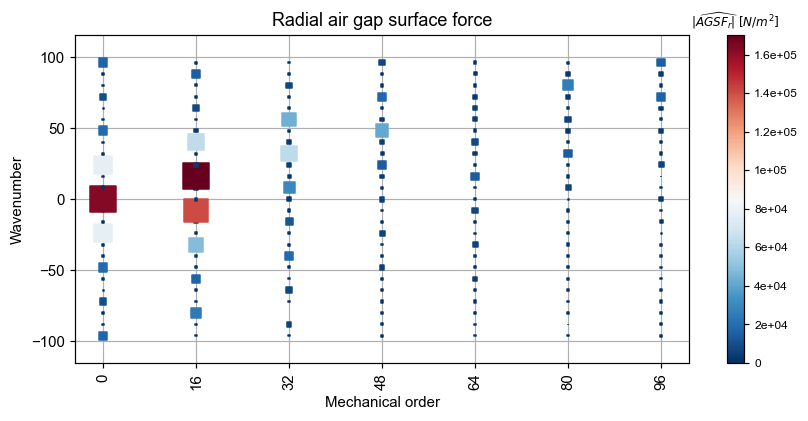

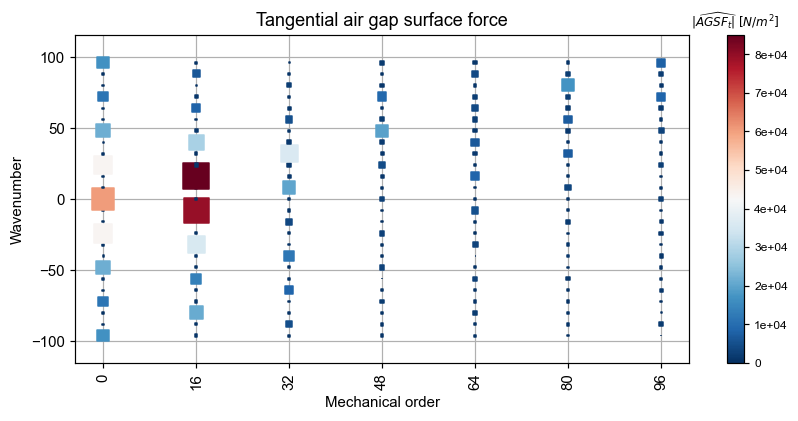

In [136]:
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-100,100]",
    N_stem=100,
)
